In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [81]:
# data from CSV files
teams_df = pd.read_csv('teams.csv')
technical_officials_df = pd.read_csv('technical_officials.csv')
events_df = pd.read_csv('events.csv')
nocs_df = pd.read_csv('nocs.csv')
schedule_preliminary_df = pd.read_csv('schedules_preliminary.csv')
schedule_df = pd.read_csv('schedules.csv')
torch_route_df = pd.read_csv('torch_route.csv')
medals_total_df = pd.read_csv('medals_total.csv')
medals_df = pd.read_csv('medals.csv')
venues_df = pd.read_csv('venues.csv')
athletes_df = pd.read_csv('athletes.csv')
coaches_df = pd.read_csv('coaches.csv')
medallists_df = pd.read_csv('medallists.csv')

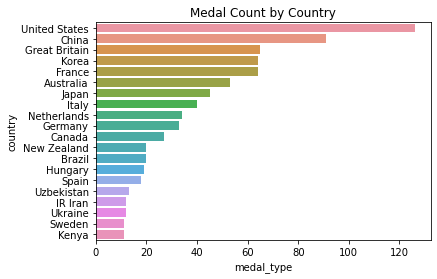

In [82]:
#1. Analyzing which countries have the highest medal counts and how their total medal count compare.
medals_by_country = pd.merge(medals_df, nocs_df, on='country').groupby('country')['medal_type'].count().reset_index()
medals_by_country = medals_by_country.sort_values(by='medal_type',ascending=False).head(20)
sns.barplot(x='medal_type', y='country', data=medals_by_country)
plt.title('Medal Count by Country')
plt.show()

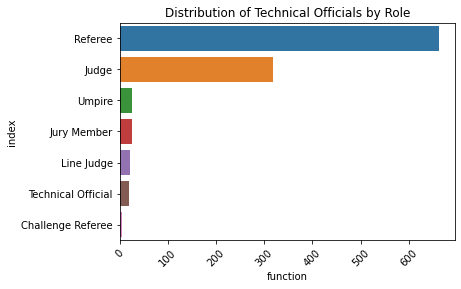

In [113]:
#2. Identifying the distribution of technical officials by roles (Judge, Referee, etc.).

officials_by_role = technical_officials_df['function'].value_counts().reset_index().head(7)
sns.barplot(x='function', y='index', data=officials_by_role)
plt.title('Distribution of Technical Officials by Role')
plt.xticks(rotation=45)
plt.show()

In [84]:
# Cleaning up the 'disciplines' column in technical_officials.csv -> this is because disciplines in this table is a list, and rest of the tables have singular data in this type of column.
import ast
technical_officials_df['disciplines'] = technical_officials_df['disciplines'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
technical_officials_df = technical_officials_df.explode('disciplines')
technical_officials_df['disciplines'] = technical_officials_df['disciplines'].str.strip()

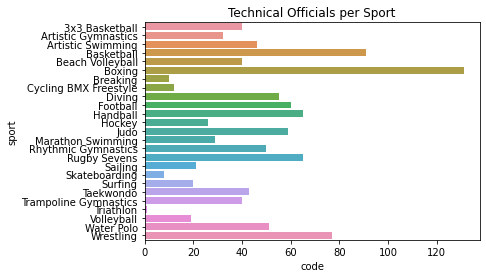

In [85]:
#3. Understanding how many technical officials are assigned to each sport.
#cleaned technical_officials_df above.
officials_by_event = pd.merge(technical_officials_df, events_df, left_on='disciplines', right_on='sport')
officials_by_event = officials_by_event.groupby('sport')['code'].nunique().reset_index()

sns.barplot(x='code', y='sport', data=officials_by_event)
plt.title('Technical Officials per Sport')
plt.show()

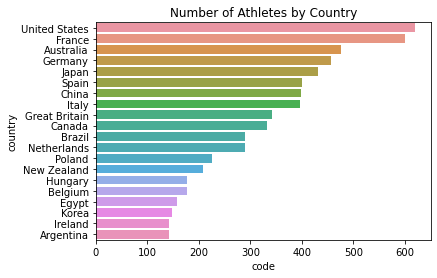

In [86]:
#4. Finding which countries have the largest number of athletes participating.

athletes_by_country = athletes_df.groupby('country')['code'].nunique().reset_index()
athletes_by_country = athletes_by_country.sort_values(by='code',ascending=False).head(20)
sns.barplot(x='code', y='country', data=athletes_by_country)
plt.title('Number of Athletes by Country')
plt.show()

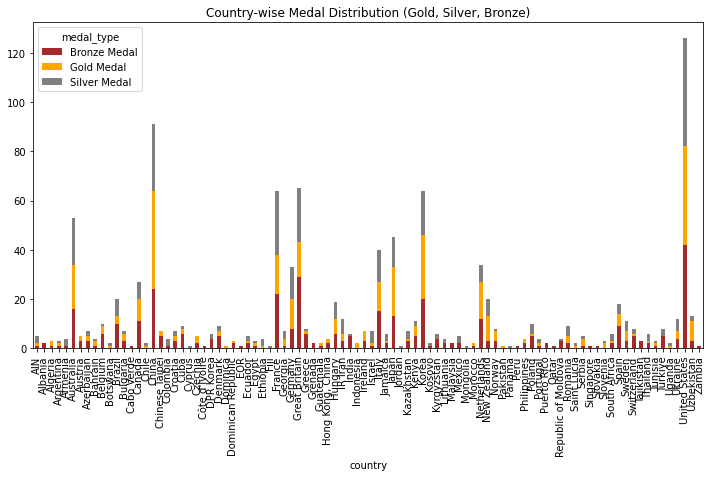

In [207]:
#5. Visualize how many Gold, Silver, and Bronze medals each country has won.
import plotly.express as px
medals_by_country = pd.merge(medals_df, nocs_df, on='country')
medals_by_country_count = medals_by_country.groupby(['country', 'medal_type'])['medal_code'].count().unstack().reset_index()

medals_by_country_count.plot(kind='bar', stacked=True, x='country', color=['brown','orange','gray'], figsize=(12,6))
plt.title('Country-wise Medal Distribution (Gold, Silver, Bronze)')
plt.xticks(rotation=90)
plt.show()

# Correlation
correlation_matrix = medals_by_country_count[['Gold Medal', 'Silver Medal', 'Bronze Medal']].corr()
fig = px.imshow(correlation_matrix, text_auto=True, title='Medal Correlation Matrix')
fig.show(renderer='iframe')

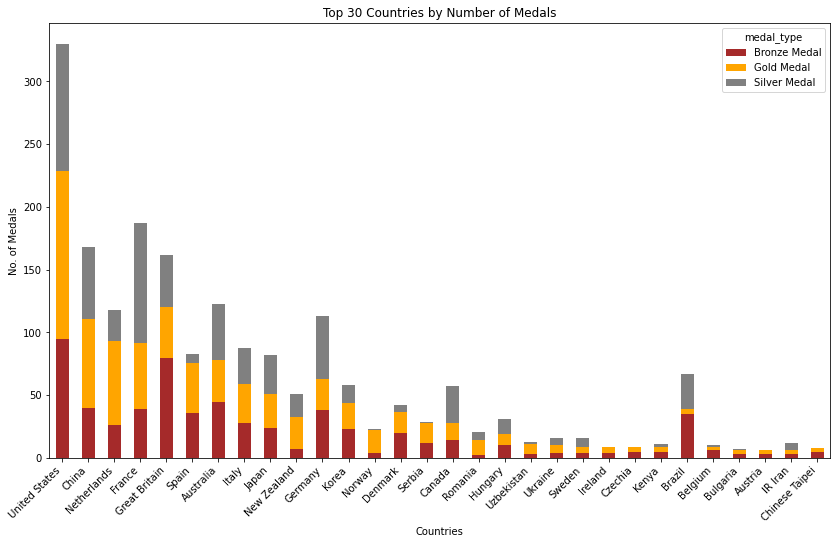

In [206]:
#6. Top 30 Countries by Number of Medals
medals_by_country_type = medallists_df.groupby(['country', 'medal_type']).size().unstack().fillna(0)

medals_by_country_type = medals_by_country_type.sort_values('Gold Medal', ascending=False).head(30)

medals_by_country_type.plot(kind='bar', stacked=True, color=['brown','orange','gray'], figsize=(14, 8))

plt.title('Top 30 Countries by Number of Medals')
plt.xlabel('Countries')
plt.ylabel('No. of Medals')
plt.xticks(rotation=45, ha="right")
plt.show()

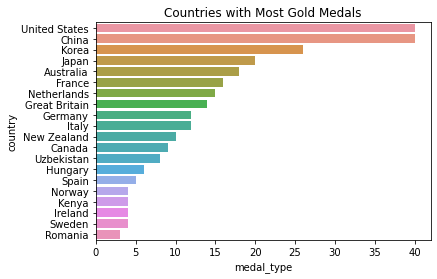

In [88]:
#7. Finding which countries have won the most gold medals.

gold_medals = medals_df[medals_df['medal_type'] == 'Gold Medal']
gold_medals_by_country = pd.merge(gold_medals, nocs_df, on='country').groupby('country')['medal_type'].count().reset_index()
gold_medals_by_country = gold_medals_by_country.sort_values(by='medal_type',ascending=False).head(20)
sns.barplot(x='medal_type', y='country', data=gold_medals_by_country)
plt.title('Countries with Most Gold Medals')
plt.show()

In [89]:
# Cleaning up the 'events' column in athletes.csv -> this is because events in this table is a list, and rest of the tables have singular data in this type of column.
import ast
athletes_df['events'] = athletes_df['events'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).head(1000)
athletes_df = athletes_df.explode('events')
athletes_df['events'] = athletes_df['events'].str.strip()

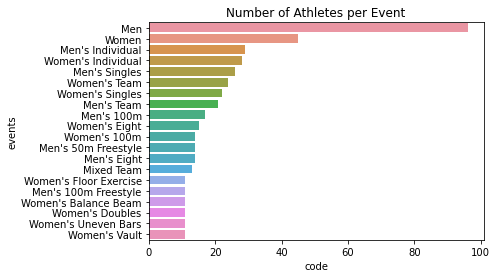

In [94]:
#8. Finding top most events that athletes participate.
#cleaned athletes_df above.
athletes_per_event = athletes_df.groupby('events')['code'].nunique().reset_index()
athletes_per_event = athletes_per_event.sort_values(by='code',ascending=False).head(20)
sns.barplot(x='code', y='events', data=athletes_per_event)
plt.title('Number of Athletes per Event')
plt.show()

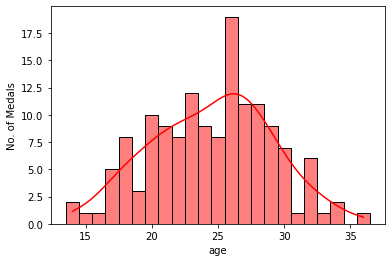

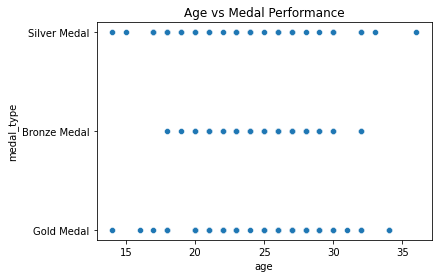

Correlation between age and medal type: 
     age
age  1.0


In [198]:
#9. Analyze the correlation between athlete age and medal performance.

#to calculate age, we're using medal receival date and birth date.
from datetime import datetime

# Function to calculate age
def calculate_age(birthdate_str, medaldate_str):
    birth_date = datetime.strptime(birthdate_str, "%Y-%m-%d")
    medal_date = datetime.strptime(medaldate_str, "%Y-%m-%d")
    
    age = medal_date.year - birth_date.year
    
    if (medal_date.month, medal_date.day) < (birth_date.month, birth_date.day):
        age -= 1
    
    return age

athletes_medals = pd.merge(athletes_df, medals_df, on='name')
athletes_medals['birth_date'] = pd.to_datetime(athletes_medals['birth_date'], errors='coerce')
athletes_medals['medal_date'] = pd.to_datetime(athletes_medals['medal_date'], errors='coerce')
athletes_medals['age'] = athletes_medals.apply(lambda row: calculate_age(row['birth_date'].strftime("%Y-%m-%d"), row['medal_date'].strftime("%Y-%m-%d")), axis=1)

bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-100']
sns.histplot(data=athletes_medals, x='age', bins=bins, discrete=True, kde=True, color='red')
plt.ylabel('No. of Medals')
plt.show()

sns.scatterplot(x='age', y='medal_type', data=athletes_medals)
plt.title('Age vs Medal Performance')
plt.show()

# Correlation
correlation = athletes_medals[['age', 'medal_type']].corr()
print(f"Correlation between age and medal type: \n{correlation}")

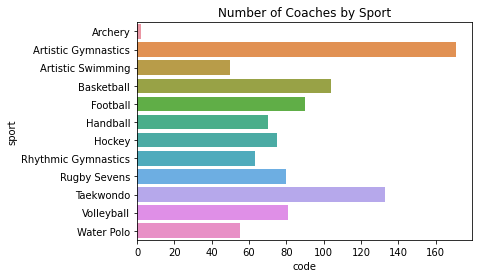

In [183]:
#10. Visualizing the number of coaches per sport.

coaches_by_sport = pd.merge(coaches_df, events_df, left_on='disciplines', right_on='sport')
coaches_by_sport_count = coaches_by_sport.groupby('sport')['code'].nunique().reset_index()

sns.barplot(x='code', y='sport', data=coaches_by_sport_count)
plt.title('Number of Coaches by Sport')
plt.show()

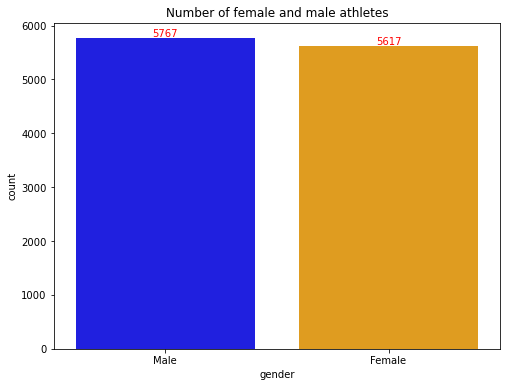

In [193]:
#11. No. of male and female athletes

plt.figure(figsize=(8,6))
ax=sns.countplot(athletes_df,x=athletes_df['gender'],palette=['blue', 'orange'])
for count in ax.patches:
    ax.annotate(f'{int(count.get_height())}', 
                (count.get_x() + count.get_width() / 2., count.get_height()), 
                ha='center', va='bottom', 
                fontsize=10,color='red'
               )
plt.title('Number of female and male athletes')
plt.show()

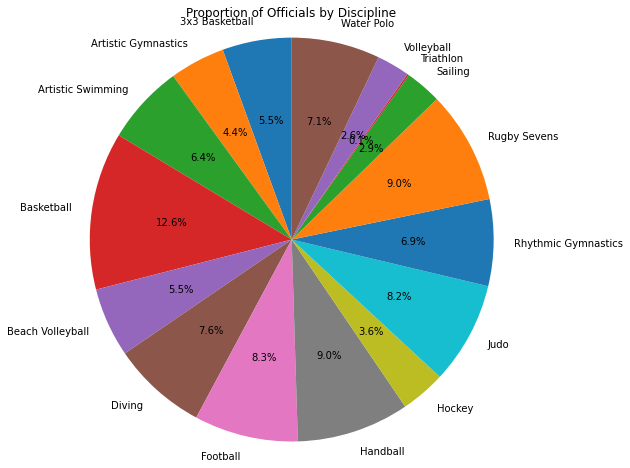

In [209]:
#12. Plot of percentage of officials per discipline
officials_per_event_df = pd.merge(technical_officials_df, events_df, left_on='disciplines', right_on='sport', how='inner')
officials_on_event_team_df = pd.merge(officials_per_event_df, teams_df, left_on='sport', right_on='discipline', how='inner')

officials_by_discipline_df = officials_on_event_team_df.groupby('disciplines')['code_x'].nunique().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(officials_by_discipline_df['code_x'], labels=officials_by_discipline_df['disciplines'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Officials by Discipline')
plt.axis('equal')
plt.show()
